# Imports

In [2]:
import numpy as np
import os
from glob import glob
import h5py
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import gc
from tensorflow.keras.callbacks import CSVLogger
import tensorflow_model_optimization as tfmot

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Converting from npy to h5

In [ ]:
# Datasets/
# └── 11G-features/
#     ├── ATM_images/
#     ├── Center_of_Mass/
#     ├── DTM_images/
#     ├── Filtered_Raw_Signals/
#     ├── RFDM_recomputed/
#     │   ├── p0_1/
#     │   │   ├── Circle/
#     │   │   │   ├── sess_0/
#     │   │   │   │   ├── sensor0/
#     │   │   │   │   │   ├── 0.npy
#     │   │   │   │   │   ├── 1.npy
#     │   │   │   │   │   └── ...
#     │   │   │   │   ├── sensor1/
#     │   │   │   │   │   ├── 0.npy
#     │   │   │   │   │   ├── 1.npy
#     │   │   │   │   │   └── ...
#     │   │   │   ├── sess_1/
#     │   │   │   ├── sess_2/
#     │   │   │   ├── sess_3/
#     │   │   │   └── sess_4/
#     │   │   ├── FastSwipeRL/
#     │   │   ├── FingerRub/
#     │   │   ├── FingerSlider/
#     │   │   ├── NoHand/
#     │   │   ├── PalmHold/
#     │   │   ├── PalmTilt/
#     │   │   ├── PinchIndex/
#     │   │   ├── PinchPinkky/
#     │   │   ├── Pull/
#     │   │   ├── Push/
#     │   │   ├── RandomGesture/
#     │   │   └── SlowSwipeRL/
#     │   ├── p0_2/
#     │   ├── p0_3/
#     │   ├── ...
#     │   ├── p0_20/
#     │   ├── p1/
#     │   ├── ...
#     │   └── p25/
#     ├── RTM_images/
#     ├── Signal_Energy_SOR/
#     ├── Signal_Energy_SOT/
#     ├── Signal_Variation_2D/
#     ├── Signal_Variation_SOR/
#     └── Signal_Variation_SOT/

In [ ]:
def convert_to_hdf5(base_path, output_path, seq_len=5):
    participants = sorted([p for p in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, p))])
    samples = []

    gesture_set = set()
    h5f = h5py.File(output_path, 'w')
    idx = 0

    for person in tqdm(participants, desc="Processing participants"):
        person_path = os.path.join(base_path, person)

        for gesture in os.listdir(person_path):
            gesture_path = os.path.join(person_path, gesture)
            if not os.path.isdir(gesture_path): continue
            gesture_set.add(gesture)

            for session in os.listdir(gesture_path):
                sess_path = os.path.join(gesture_path, session)
                sensor0_files = sorted(glob(os.path.join(sess_path, 'sensor0', '*.npy')))
                sensor1_files = sorted(glob(os.path.join(sess_path, 'sensor1', '*.npy')))
                num_frames = min(len(sensor0_files), len(sensor1_files))

                for i in range(num_frames - seq_len + 1):
                    try:
                        seq = []
                        for j in range(seq_len):
                            s0 = np.load(sensor0_files[i+j])
                            s1 = np.load(sensor1_files[i+j])
                            frame = np.stack((s0, s1), axis=-1)  # (32, 492, 2)
                            seq.append(frame)
                        seq = np.array(seq)  # (5, 32, 492, 2)
                        h5f.create_dataset(f'sample_{idx}/X', data=seq, compression='gzip')
                        h5f.create_dataset(f'sample_{idx}/label', data=np.string_(gesture))
                        idx += 1
                    except Exception as e:
                        print(f"Error loading sequence {i}: {e}")

    h5f.attrs['gesture_list'] = list(gesture_set)
    h5f.close()
    print(f"Saved {idx} sequences to {output_path}")

# Example usage:
convert_to_hdf5(
    base_path=r'\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Datasets\11G-features\RFDM_recomputed',
    output_path=r'\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Datasets\11G-features\rfdm_sequences.h5',
    seq_len=5
)

In [ ]:
def recover_hdf5_data(broken_path, output_path):
    recovered_count = 0

    with h5py.File(broken_path, 'r') as src:
        sample_keys = [k for k in src.keys() if k.startswith("sample_")]
        with h5py.File(output_path, 'w') as dst:
            for key in tqdm(sample_keys, desc="Recovering samples"):
                try:
                    # Read data from broken file
                    X = src[f"{key}/X"][:]
                    label = src[f"{key}/label"][()].decode('utf-8')

                    # Save into new file
                    dst.create_dataset(f"{key}/X", data=X, compression="gzip")
                    dst.create_dataset(f"{key}/label", data=np.string_(label))
                    recovered_count += 1

                except Exception as e:
                    print(f"Skipping {key}: {e}")

    print(f"Recovered {recovered_count} samples into: {output_path}")

In [ ]:
recover_hdf5_data(
    broken_path=r'\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Datasets\11G-features\rfdm_sequences.h5',
    output_path=r'\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Datasets\11G-features\rfdm_sequences_v2.h5'
)

# Dataset Preparation

In [3]:
def split_hdf5_indices(h5_path, random_state=42):
    with h5py.File(h5_path, 'r') as h5f:
        sample_keys = sorted([k for k in h5f.keys() if k.startswith('sample_')])
        total_samples = len(sample_keys)

        # Load labels
        labels = []
        for key in sample_keys:
            label = h5f[f"{key}/label"][()].decode('utf-8')
            labels.append(label)

    # Create label map
    unique_labels = sorted(set(labels))
    label_map = {gesture: idx for idx, gesture in enumerate(unique_labels)}

    indices = np.arange(total_samples)

    # First split: train (70%) vs temp (30%)
    train_idx, temp_idx, train_labels, temp_labels = train_test_split(
        indices, [labels[i] for i in indices],
        test_size=0.3,
        stratify=[labels[i] for i in indices],
        random_state=random_state
    )

    # Second split: val (20%) vs test (10%) from the temp 30%
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=1/3,  # 1/3 of 30% = 10%
        stratify=[labels[i] for i in temp_idx],
        random_state=random_state
    )

    return train_idx, val_idx, test_idx, label_map

In [4]:
class HDF5SequenceGenerator(Sequence):
    def __init__(self, h5_path, sample_keys, label_map, batch_size=128, shuffle=False):
        """
        Args:
            h5_path (str): Path to the HDF5 file.
            sample_keys (list[str]): List of sample keys (e.g., ['sample_0', 'sample_1']) for the split.
            label_map (dict): Map from gesture name to integer label.
            batch_size (int): Batch size.
            shuffle (bool): Whether to shuffle samples each epoch.
        """
        self.h5_path = h5_path
        self.sample_keys = sample_keys
        self.label_map = label_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.sample_keys) / self.batch_size))

    def __getitem__(self, index):
        batch_keys = self.sample_keys[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []

        with h5py.File(self.h5_path, 'r') as h5f:
            for key in batch_keys:
                try:
                    X = h5f[f"{key}/X"][:]  # Load the full frame sequence
                    label = h5f[f"{key}/label"][()].decode('utf-8')
                    X_batch.append(X)
                    y_batch.append(self.label_map[label])
                except KeyError:
                    print(f"⚠️ Skipping incomplete or corrupt sample: {key}")
                    gc.collect()  # only collect if needed

        return np.array(X_batch), np.array(y_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.sample_keys)

In [5]:
def get_valid_sample_keys(h5_path):
    valid_keys = []
    labels = []

    with h5py.File(h5_path, 'r') as h5f:
        for key in sorted(h5f.keys()):
            if not key.startswith('sample_'):
                continue
            try:
                _ = h5f[f"{key}/X"]
                label = h5f[f"{key}/label"][()].decode('utf-8')
                valid_keys.append(key)
                labels.append(label)
            except KeyError:
                print(f"⚠️ Skipping incomplete or corrupt sample: {key}")
        gc.collect()  
    return valid_keys, labels

In [ ]:
HDF5_PATH = r'\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Datasets\11G-features\rfdm_sequences_v2.h5'
valid_keys, labels = get_valid_sample_keys(HDF5_PATH)

# Build label map
unique_labels = sorted(set(labels))
label_map = {g: i for i, g in enumerate(unique_labels)}

# Stratified split
indices = np.arange(len(valid_keys))

train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    indices, [labels[i] for i in indices],
    test_size=0.3,
    stratify=[labels[i] for i in indices],
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=1/3,
    stratify=[temp_labels[i] for i in range(len(temp_idx))],
    random_state=42
)

# Convert to sample key lists
train_keys = [valid_keys[i] for i in train_idx]
val_keys   = [valid_keys[i] for i in val_idx]
test_keys  = [valid_keys[i] for i in test_idx]

In [7]:
train_gen = HDF5SequenceGenerator(HDF5_PATH, train_keys, label_map, batch_size=256, shuffle=True)
val_gen   = HDF5SequenceGenerator(HDF5_PATH, val_keys, label_map, batch_size=256)
test_gen  = HDF5SequenceGenerator(HDF5_PATH, test_keys, label_map, batch_size=256)

In [8]:
# see how many training samples we have - using just the first 13 people
print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Test samples: {len(test_idx)}")

Training samples: 109922
Validation samples: 31406
Test samples: 15704


# Model

| Component       | Paper                        | This Version                              | Why the Change?                              |
| --------------- | ---------------------------- | ----------------------------------------- | -------------------------------------------- |
| **Conv2D only** | Standard convs               | Added **BatchNorm** + **ReLU separately** | Better gradient flow and convergence         |
| **TCN layers**  | Causal Conv1D with residuals | Uses **Dropout in residuals**             | Helps prevent overfitting                    |
| **Conv1D type** | Standard 1D convs            | Uses **SeparableConv1D**                  | More efficient, edge-friendly                |
| **Flatten**     | Yes                          | Same                                      | Paper uses this for dimensionality reduction |
| **FC layers**   | 3-layer classifier           | Added **Dropout after FCs**               | Enhances generalization                      |
| **Residuals**   | Add only                     | Dropout + Residual                        | More robust to overfitting                   |


In [9]:
def build_cnn_encoder():
    input_layer = tf.keras.Input(shape=(32, 492, 2))  # One frame

    x = layers.Conv2D(16, (3, 5), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 5), padding='valid')(x)

    x = layers.Conv2D(32, (3, 5), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 5), padding='valid')(x)

    x = layers.Conv2D(64, (1, 7), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(1, 7), padding='valid')(x)

    x = layers.Flatten()(x)  # Output shape: (384,)
    return models.Model(inputs=input_layer, outputs=x, name="Optimized_CNN_Encoder")

In [10]:
def build_full_cnn_tcn_model(seq_len=5, frame_shape=(32, 492, 2), num_classes=11):
    input_layer = tf.keras.Input(shape=(seq_len, *frame_shape))  # (5, 32, 492, 2)

    cnn_encoder = build_cnn_encoder()
    x = layers.TimeDistributed(cnn_encoder)(input_layer)  # (5, 384)

    # Compress channels with separable conv (more efficient)
    x = layers.SeparableConv1D(32, 1, padding='causal', activation='relu')(x)
    x_skip = x

    # Dilated residual TCN blocks with dropout
    for dilation_rate in [1, 2, 4]:
        residual = layers.SeparableConv1D(
            32, kernel_size=2, padding='causal', dilation_rate=dilation_rate,
            activation='relu'
        )(x)
        residual = layers.Dropout(0.2)(residual)
        x = layers.Add()([x, residual])
        x_skip = x  # update skip for chained residual

    # Fully connected layers with dropout
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)

    # Use last time step only
    x = layers.Lambda(lambda t: t[:, -1, :])(x)

    output = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    return models.Model(inputs=input_layer, outputs=output, name="CNN_TCN_Optimized")


# Training and testing

In [12]:
class TQDMProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_gen):
        super().__init__()
        self.test_gen = test_gen

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_pbar = tqdm(total=len(self.model.history.epoch) + 1, desc=f"Epoch {epoch + 1}", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_pbar.update(1)
        self.epoch_pbar.close()
        loss, acc = self.model.evaluate(self.test_gen, verbose=0)
        print(f"Epoch {epoch + 1}: Test Accuracy = {acc:.4f}")

test_callback = TQDMProgressCallback(test_gen)

In [13]:
class BatchCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, save_dir, label_map, every_n_batches=100):
        super().__init__()
        self.save_dir = save_dir
        self.every_n_batches = every_n_batches
        self.label_map = label_map
        self.batch_count = 0
        os.makedirs(save_dir, exist_ok=True)

    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.every_n_batches == 0:
            acc = logs.get('accuracy', 0.0)
            filename = f"{self.save_dir}/epoch1/batch{self.batch_count:05d}_acc{acc:.4f}.h5"
            self.model.save(filename)
            print(f"\n Saved checkpoint: {filename}")

In [14]:
# model = load_model(r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Models\tiny_radar_NN\batch_checkpoints\batch01600_acc0.8072.h5')
model = build_full_cnn_tcn_model(seq_len=5, num_classes=len(label_map))
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "CNN_TCN_Optimized"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 32, 492,  0           []                               
                                 2)]                                                              
                                                                                                  
 time_distributed (TimeDistribu  (None, 5, 384)      23056       ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 separable_conv1d (SeparableCon  (None, 5, 32)       12704       ['time_distributed[0][0]']       
 v1D)                                                                             

In [ ]:
# Add CSVLogger to save training metrics
csv_logger = CSVLogger('Models/tiny_radar_NN/training_log.csv', append=True)

# Build and compile model
checkpoint_cb = ModelCheckpoint(
    filepath='Models/tiny_radar_NN/best_model_epoch_{epoch:02d}_valacc{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

batch_checkpoint_cb = BatchCheckpoint(
    save_dir='Models/tiny_radar_NN/new_batch_checkpoints',
    label_map=label_map,
    every_n_batches=100  # saves every 100 batches (roughly 3x per epoch)
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[
        test_callback,
        checkpoint_cb,
        batch_checkpoint_cb,
        csv_logger  # Add this to log metrics
    ],
    workers=0, 
    use_multiprocessing=False,  # Enable multiprocessing
    max_queue_size=20  # Increase queue size to prevent bottlenecks
)

In [17]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Final Test Accuracy: {test_acc:.4f}")

62/62 [==============================] - 73s 1s/step - loss: 0.1813 - accuracy: 0.9433

 Final Test Accuracy: 0.9433


In [ ]:
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    X_corrected = X_batch.reshape(-1,5,32,492,2)
    preds = model.predict(X_corrected, verbose=0)
    y_true.extend(y_batch)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

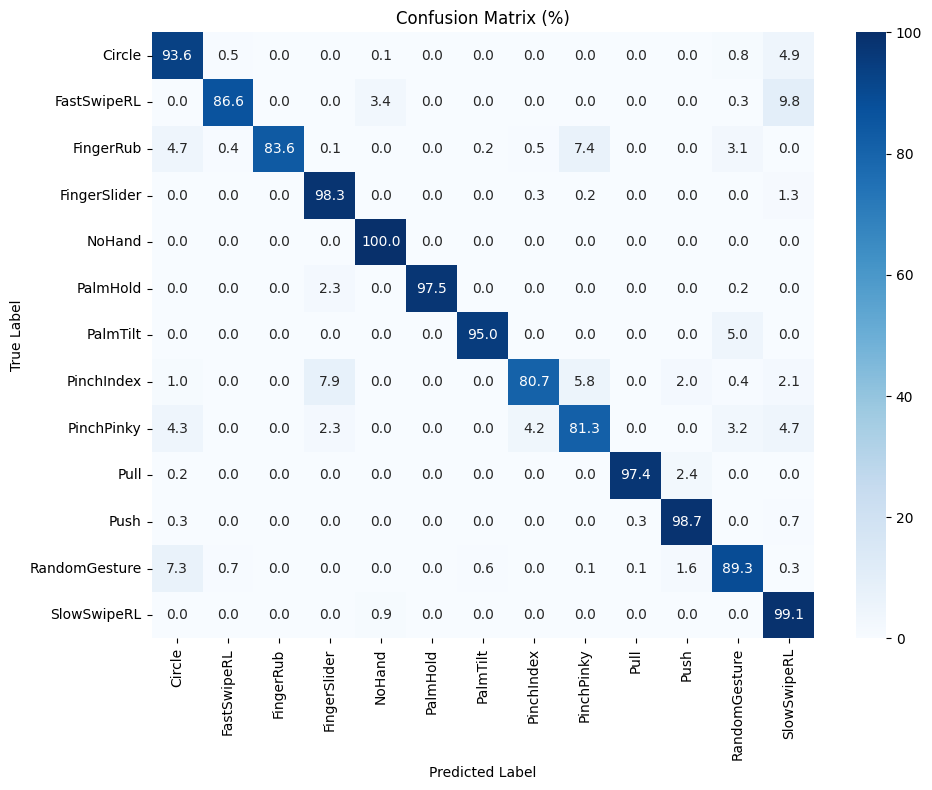

In [30]:
valid_mask = y_true != 0
y_true_clean = y_true[valid_mask]
y_pred_clean = y_pred[valid_mask]

gesture_names = [name for name, idx in sorted(label_map.items(), key=lambda x: x[1]) if idx != 0]
cm = confusion_matrix(y_true_clean, y_pred_clean)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (%)")
plt.tight_layout()
plt.show()


In [31]:
print("\nClassification Report (Excluding invalid class):")
print(classification_report(y_true_clean, y_pred_clean, target_names=gesture_names, digits=4))



Classification Report (Excluding invalid class):
               precision    recall  f1-score   support

       Circle     0.8848    0.9362    0.9098      1427
  FastSwipeRL     0.9421    0.8655    0.9022       357
    FingerRub     1.0000    0.8363    0.9108      1142
 FingerSlider     0.9282    0.9827    0.9547      1329
       NoHand     0.9897    1.0000    0.9948      2893
     PalmHold     1.0000    0.9753    0.9875      1091
     PalmTilt     0.9927    0.9504    0.9711      1150
   PinchIndex     0.9282    0.8071    0.8634       705
   PinchPinky     0.8374    0.8126    0.8248       811
         Pull     0.9961    0.9736    0.9848      1062
         Push     0.9478    0.9874    0.9672      1029
RandomGesture     0.8682    0.8933    0.8806      1003
  SlowSwipeRL     0.9010    0.9906    0.9437      1699

     accuracy                         0.9436     15698
    macro avg     0.9397    0.9239    0.9304     15698
 weighted avg     0.9453    0.9436    0.9432     15698



In [32]:
model.summary()

Model: "CNN_TCN_Optimized"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 32, 492,  0           []                               
                                 2)]                                                              
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 5, 384)      23056       ['input_3[0][0]']                
 buted)                                                                                           
                                                                                                  
 separable_conv1d_4 (SeparableC  (None, 5, 32)       12704       ['time_distributed_1[0][0]']     
 onv1D)                                                                           

In [ ]:
model_path = r'\Code\model_training\Models\tiny_radar_NN\best_model_epoch_09_valacc0.9544.h5'
size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"Model size: {size_mb:.2f} MB")

Model size: 0.64 MB


# Transforming to Tflite

In [ ]:
model_path = r'\Code\model_training\Models\tiny_radar_NN\best_model_epoch_09_valacc0.9544.h5'

In [ ]:
model = tf.keras.models.load_model(model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,     # enable standard ops
    tf.lite.OpsSet.SELECT_TF_OPS        # enable TensorFlow fallback ops
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]

tflite_model = converter.convert()
with open("tinyNN_float32.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpuar79kta\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpuar79kta\assets


# Quantization Float 16

In [10]:
def build_full_cnn_tcn_model_mod(seq_len=5, frame_shape=(32, 492, 2), num_classes=11):
    input_layer = tf.keras.Input(shape=(seq_len, *frame_shape))  # (5, 32, 492, 2)

    cnn_encoder = build_cnn_encoder()
    x = layers.TimeDistributed(cnn_encoder)(input_layer)  # (5, 384)

    # Compress channels with separable conv (more efficient)
    x = layers.SeparableConv1D(32, 1, padding='same', activation='relu')(x)
    x_skip = x

    # Dilated residual TCN blocks with dropout
    for dilation_rate in [1, 2, 4]:
        residual = layers.SeparableConv1D(
            32, kernel_size=2, padding='same', dilation_rate=dilation_rate,
            activation='relu'
        )(x)
        residual = layers.Dropout(0.2)(residual)
        x = layers.Add()([x, residual])
        x_skip = x  # update skip for chained residual

    # Fully connected layers with dropout
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)

    # Use last time step only
    x = layers.GlobalAveragePooling1D()(x)

    output = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    return models.Model(inputs=input_layer, outputs=output, name="CNN_TCN_Optimized")


In [ ]:
model_path = r'\Code\model_training\Models\tiny_radar_NN\best_model_epoch_09_valacc0.9544.h5'
model = tf.keras.models.load_model(model_path)

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,     # enable standard ops
    tf.lite.OpsSet.SELECT_TF_OPS        # enable TensorFlow fallback ops
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()
with open("model_fp16_flex.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpfdwiahhp\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpfdwiahhp\assets


In [24]:
def predict_with_correction_tflite(interpreter, generator):
    y_true, y_pred = [], []

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_dtype = input_details[0]['dtype']
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    for X_batch, y_batch in generator:
        X_corrected = X_batch.reshape(-1, 5, 32, 492, 2).astype(input_dtype)

        for i in range(X_corrected.shape[0]):
            sample = X_corrected[i:i+1]  # Single sample, still 5D
            interpreter.set_tensor(input_index, sample)
            interpreter.invoke()
            output = interpreter.get_tensor(output_index)
            y_pred.append(np.argmax(output))
            y_true.append(y_batch[i])
        
        gc.collect()  # Clean up batch memory

    return np.array(y_true), np.array(y_pred)

interpreter = tf.lite.Interpreter(model_path="model_fp16_flex.tflite")
interpreter.allocate_tensors()

y_true, y_pred = predict_with_correction_tflite(interpreter, test_gen)
manual_acc = np.mean(y_true == y_pred)
print(f"TFLite model manual accuracy: {manual_acc:.4f}")

TFLite model manual accuracy: 0.9593


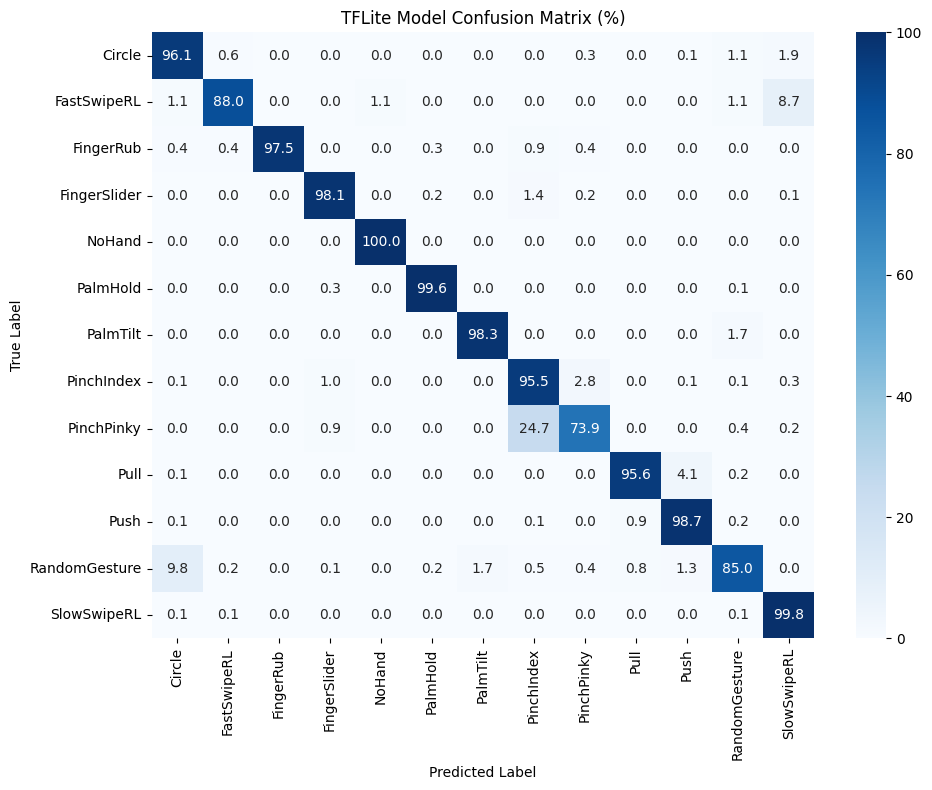


Classification Report (Excluding invalid class):
               precision    recall  f1-score   support

       Circle     0.9245    0.9608    0.9423      1427
  FastSwipeRL     0.9515    0.8796    0.9141       357
    FingerRub     1.0000    0.9755    0.9876      1142
 FingerSlider     0.9864    0.9812    0.9838      1329
       NoHand     0.9986    1.0000    0.9993      2893
     PalmHold     0.9927    0.9963    0.9945      1091
     PalmTilt     0.9852    0.9835    0.9843      1150
   PinchIndex     0.7412    0.9546    0.8345       705
   PinchPinky     0.9448    0.7386    0.8291       811
         Pull     0.9835    0.9557    0.9694      1062
         Push     0.9451    0.9874    0.9658      1029
RandomGesture     0.9457    0.8504    0.8955      1003
  SlowSwipeRL     0.9642    0.9976    0.9806      1699

     accuracy                         0.9597     15698
    macro avg     0.9510    0.9432    0.9447     15698
 weighted avg     0.9625    0.9597    0.9595     15698



In [25]:
valid_mask = y_true != 0
y_true_clean = y_true[valid_mask]
y_pred_clean = y_pred[valid_mask]

# Get gesture names (excluding label 0)
gesture_names = [name for name, idx in sorted(label_map.items(), key=lambda x: x[1]) if idx != 0]

# Compute normalized confusion matrix
cm = confusion_matrix(y_true_clean, y_pred_clean)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("TFLite Model Confusion Matrix (%)")
plt.tight_layout()
plt.show()

# Optional: Classification report
print("\nClassification Report (Excluding invalid class):")
print(classification_report(y_true_clean, y_pred_clean, target_names=gesture_names, digits=4))

In [27]:
# check model size
model_size_mb = os.path.getsize("model_fp16_flex.tflite") / (1024 * 1024)
print(f"TFLite model size: {model_size_mb:.2f} MB")

TFLite model size: 0.12 MB


# Quantize Int8

In [ ]:
model_path = r'\Code\model_training\Models\tiny_radar_NN\best_model_epoch_09_valacc0.9544.h5'
model = tf.keras.models.load_model(model_path)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [20]:
def convert_model_to_fp32(model_path):
    # Load model with explicit float32 policy
    policy = tf.keras.mixed_precision.Policy('float32')
    tf.keras.mixed_precision.set_global_policy(policy)
    
    # Load model with new policy
    model = tf.keras.models.load_model(model_path)
    return model

model = convert_model_to_fp32(model_path)

In [12]:
def representative_data_gen():
    for X_batch, _ in test_gen:
        X_corrected = X_batch.reshape(-1, 5, 32, 492, 2).astype(np.float32)
        for i in range(min(100, X_corrected.shape[0])):
            yield [X_corrected[i:i+1]]
        break

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Fallback to float ops for unsupported layers
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    #tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Keep input/output as float32 for safety
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert
try:
    tflite_model = converter.convert()
    with open("quantized_model_int8_corrected.tflite", "wb") as f:
        f.write(tflite_model)
    print("Model successfully quantized to INT8 with TF ops fallback")
    
    # Verify model size
    import os
    print(f"Model size: {os.path.getsize('quantized_model_int8_corrected.tflite')/1024:.2f} KB")
    
except Exception as e:
    print(f"Conversion failed: {str(e)}")

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmp02umjfmz\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmp02umjfmz\assets
c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model successfully quantized to INT8 with TF ops fallback
Model size: 88.78 KB


In [13]:
interpreter = tf.lite.Interpreter(model_path="quantized_model_int8_corrected.tflite")
interpreter.allocate_tensors()
# Get input details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

delegates = interpreter._delegates if hasattr(interpreter, '_delegates') else []
print("Delegates used:", delegates)

Delegates used: []


In [14]:
print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1,   5,  32, 492,   2]), 'shape_signature': array([ -1,   5,  32, 492,   2]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 178, 'shape': array([ 1, 14]), 'shape_signature': array([-1, 14]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# Load model WITHOUT any delegates (no GPU, no XNNPACK)
interpreter = tf.lite.Interpreter(
    model_path="quantized_model_int8_corrected.tflite",
    experimental_delegates=[]
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

output_scale, output_zero_point = output_details[0]['quantization']

# Prepare sample input
sample_input, _ = next(iter(test_gen))
sample_input = sample_input.reshape(-1, 5, 32, 492, 2).astype(np.float32)

# Run inference
interpreter.set_tensor(input_details[0]['index'], sample_input[:1])
interpreter.invoke()

# Output
quant_output = interpreter.get_tensor(output_details[0]['index'])
dequant_output = (quant_output.astype(np.float32) - output_zero_point) * output_scale

# Original model
float_output = model.predict(sample_input[:1])

print("Original model output:", float_output.argmax())
print("Quantized model output:", dequant_output.argmax())
print("Output similarity:", np.allclose(float_output, dequant_output, atol=0.1))
